# Zyfra Gold Recovery Model

# Contents <a id='back'></a>

* [Introduction](#introduction)
* [Data Overview](#data_overview)
    * [Initialization](#initialization)
    * [Load Data](load_data)
* [Prepare the Data](#prepare_data)
    * [Fix Data](#fix_data)
    * [Check for Duplicates](#duplicates)
    * [Check for Missing Values](#missing_values)
* [Analyze the Data](#analysis)
* [Build the Model](#build_model)
    * [Function to Calculate Final sMAPE Value](#smape_function)
    * [Train a Model](#train_model)
        * [Random Forest Model](#random_forest)
        * [Linear Regression Model](#linear_regression)
        * [Decision Tree Model](#decision_tree)
        * [Hyperparameter Tuning](#hyperparameter_tuning)
    * [Final Model](#final_model)
* [Conclusion](#conclusion)

# Introduction <a id='introduction'></a>

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

The provided data is stored in the following files: `/datasets/gold_recovery_train.csv`, `/datasets/gold_recovery_test.csv`, `/datasets/gold_recovery_full.csv`.

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.
Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse.

[Back to Contents](#back)

# Data Overview <a id='data_overview'></a>

## Initialization <a id='initialization'></a> <a class="tocSkip">

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.dummy import DummyRegressor

## Load data <a id='load_data'></a> <a class="tocSkip">

In [2]:
# Reading the dataframe files and storing it
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

# Prepare the data <a id='prepare_data'></a>

In [3]:
# Print the general/summary information about the DataFrame
train_df.info()
print()

test_df.info()
print()

full_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
# Print a sample of the data
display(train_df.head())
display(test_df.head())
display(full_df.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


## Fix Data <a id='fix_data'></a> <a class="tocSkip">

In [5]:
# Create a function to calculate the recovery.
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

# Calculate the recovery for rows that don't have NaN in rougher.output.recovery.
vals_pred = recovery(train_df.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
vals_act = train_df['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(vals_act, vals_pred)}")

Mean Absolute Error: 9.303415616264301e-15


A Mean Absolute Error (MAE) value of approximately 9.3034e-15 (in scientific notation) is extremely close to zero. This indicates that the actual and calculated values are very similar and that there is almost no difference between them. In other words, the model or method you used to calculate the "recovery" is very accurate in predicting the "rougher.output.recovery" in the dataset.

In [6]:
# Analyze the features not available in the test set
display(test_df.columns)

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

Of the possible values for parameter types (input, output, state, and calcualtion), the test set does not contain output and calculation. The parameters are listed at the end based on this formatting [stage].[parameter_type].[parameter_name]. Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

## Check for Duplicates <a id='duplicates'></a> <a class="tocSkip">

In [7]:
# checking for duplicated rows
print(train_df.duplicated().sum())
print()

print(test_df.duplicated().sum())
print()

print(full_df.duplicated().sum())
print()

0

0

0



There appear to be no duplicate rows.

## Check for Missing Values <a id='missing_values'></a> <a class="tocSkip">

In [8]:
# calculating missing values
print(train_df.isna().sum())
print()

print(test_df.isna().sum())
print()

print(full_df.isna().sum())
print()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.fl

All three dataframes appear to contain missing values.

In [9]:
# Find rows with missing values in train_df
train_missing_values = train_df[train_df.isnull().any(axis=1)]
display(train_missing_values)

# Find rows with missing values in train_df
test_missing_values = test_df[test_df.isnull().any(axis=1)]
display(test_missing_values)

# Find rows with missing values in train_df
full_missing_values = full_df[full_df.isnull().any(axis=1)]
display(full_missing_values)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,NaN,43.389252,NaN,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218
50,2016-01-17 02:00:00,8.162896,8.877528,NaN,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,13.984906,-550.563329,11.999730,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929
53,2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16846,2018-08-17 21:59:59,3.599454,12.308172,6.512304,45.477834,59.871040,8.882691,3.036575,9.421421,1.826293,...,22.988173,-500.989518,20.005718,-500.154032,17.987716,-501.022243,13.020843,-500.218430,20.011456,-499.842173
16847,2018-08-17 22:59:59,3.540800,12.423927,6.702631,45.323979,70.477689,8.866079,2.816357,9.838458,1.439220,...,23.036427,-500.990672,20.023346,-500.147796,18.010037,-500.299851,12.982786,-500.097885,20.003557,-506.135132
16848,2018-08-17 23:59:59,3.573966,12.199649,6.584768,45.440494,74.594019,9.042359,2.980534,9.737694,1.455128,...,23.011485,-500.714430,20.058045,-499.066195,17.990312,-499.278862,13.002126,-499.724599,20.004410,-500.347623
16849,2018-08-18 00:59:59,3.525247,12.121578,6.605982,45.785582,75.185602,9.041052,3.208360,9.792629,1.534906,...,23.035611,-501.134671,19.984883,-501.051735,17.948892,-500.147451,13.009772,-500.081309,20.012084,-501.651764


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
30,2016-09-02 06:59:59,NaN,NaN,7.1600,NaN,4.126292e+02,-795.316337,4.137033e+02,-787.396567,4.416043e+02,...,6.576244e+00,-616.550019,4.625908e+00,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
31,2016-09-02 07:59:59,5.039223,NaN,7.1600,NaN,1.436850e+03,-542.923353,1.549141e+03,-528.601849,1.548665e+03,...,1.193514e+01,-496.491878,7.967571e+00,-527.714564,8.191769,-517.004063,4.906812,-531.125899,10.002271,-527.901468
32,2016-09-02 08:59:59,0.857926,NaN,7.1600,NaN,1.435628e+03,-499.752988,1.550872e+03,-500.348180,1.513760e+03,...,1.192112e+01,-500.796461,7.988670e+00,-501.212454,8.067387,-501.622580,5.067141,-499.295523,9.989370,-500.350093
33,2016-09-02 09:59:59,24.616337,0.600245,7.1600,0.196905,1.437686e+03,-498.718550,1.549223e+03,-498.417613,1.510245e+03,...,1.200266e+01,-499.113047,8.061677e+00,-495.442389,8.079009,-495.166033,5.171338,-479.361256,10.056638,-498.991980
34,2016-09-02 10:59:59,64.558863,0.061864,7.1095,0.520084,1.433955e+03,-499.688476,1.553150e+03,-500.878552,1.517895e+03,...,1.199375e+01,-499.148736,8.129055e+00,-500.125308,8.031323,-486.756657,5.047491,-467.938124,10.047098,-499.813489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,2017-12-26 17:59:59,66.671316,4.982771,5.8000,0.546054,1.601798e+03,-399.342516,1.601004e+03,-399.589165,1.309597e+03,...,1.997038e+01,-499.739051,1.503472e+01,-499.893765,11.005241,-498.989282,9.046014,-499.756903,11.983336,-498.917245
5746,2017-12-27 10:59:59,NaN,NaN,7.2000,0.028131,7.805874e-32,-782.505268,9.528241e-32,-496.652939,5.781792e-32,...,2.706261e-10,-799.798523,2.030172e-10,-800.836914,0.069227,-796.857296,0.528083,-800.220337,-0.079426,-742.843140
5747,2017-12-27 11:59:59,7.469704,NaN,7.2000,0.004984,5.445860e-32,-782.195107,6.647490e-32,-496.247779,4.033736e-32,...,3.265143e+00,-799.427634,1.080343e+00,-799.879409,0.200600,-797.323986,1.420606,-800.118587,0.016815,-789.840007
5748,2017-12-27 12:59:59,5.630580,NaN,7.2000,NaN,9.261879e+02,-686.329732,9.278570e+02,-548.715931,8.940153e+02,...,5.882153e+00,-798.499014,3.409673e+00,-799.002255,2.406223,-797.219304,2.938882,-800.082169,2.454536,-803.594266


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,NaN,43.389252,NaN,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218
50,2016-01-17 02:00:00,8.162896,8.877528,NaN,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,13.984906,-550.563329,11.999730,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929
53,2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22702,2018-08-17 21:59:59,3.599454,12.308172,6.512304,45.477834,59.871040,8.882691,3.036575,9.421421,1.826293,...,22.988173,-500.989518,20.005718,-500.154032,17.987716,-501.022243,13.020843,-500.218430,20.011456,-499.842173
22703,2018-08-17 22:59:59,3.540800,12.423927,6.702631,45.323979,70.477689,8.866079,2.816357,9.838458,1.439220,...,23.036427,-500.990672,20.023346,-500.147796,18.010037,-500.299851,12.982786,-500.097885,20.003557,-506.135132
22704,2018-08-17 23:59:59,3.573966,12.199649,6.584768,45.440494,74.594019,9.042359,2.980534,9.737694,1.455128,...,23.011485,-500.714430,20.058045,-499.066195,17.990312,-499.278862,13.002126,-499.724599,20.004410,-500.347623
22705,2018-08-18 00:59:59,3.525247,12.121578,6.605982,45.785582,75.185602,9.041052,3.208360,9.792629,1.534906,...,23.035611,-501.134671,19.984883,-501.051735,17.948892,-500.147451,13.009772,-500.081309,20.012084,-501.651764


NaN appears to be used as the missing values placeholder.

In [10]:
# Drop rows with missing target values (test_df does not contain target)
train_df = train_df.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
full_df = full_df.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# Use forward fill to fill missing values
train_df = train_df.ffill()
test_df = test_df.ffill()
full_df = full_df.ffill()

# Confirm no more missing values
print(train_df.isna().sum())
print()

print(test_df.isna().sum())
print()

print(full_df.isna().sum())
print()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleane

Rows with missing targets were dropped in order to accurately calculate the error of our models. Data is indexed with the date and time of acquisition (date feature), and parameters that are next to each other in terms of time are often similar. Thus forwad fill was used to fill missing values with the last known value.

# Analyze the Data <a id='analysis'></a> <a class="tocSkip">

In [11]:
# Calculate mean concentrations at different stages
mean_concentration_raw_feed = full_df[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']].mean()
mean_concentration_rougher_concentrate = full_df[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].mean()
mean_concentration_final_concentrate = full_df[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']].mean()

print("Mean concentrations in raw feed:", mean_concentration_raw_feed)
print()
print("Mean concentrations in rougher concentrate:", mean_concentration_rougher_concentrate)
print()
print("Mean concentrations in final concentrate:", mean_concentration_final_concentrate)

Mean concentrations in raw feed: rougher.input.feed_ag    8.794927
rougher.input.feed_pb    3.585096
rougher.input.feed_au    8.266097
dtype: float64

Mean concentrations in rougher concentrate: rougher.output.concentrate_ag    11.994759
rougher.output.concentrate_pb     7.606272
rougher.output.concentrate_au    19.772000
dtype: float64

Mean concentrations in final concentrate: final.output.concentrate_ag     5.168387
final.output.concentrate_pb     9.978821
final.output.concentrate_au    44.076513
dtype: float64


In the raw feed:
Mean concentration of Ag (Silver): 8.03%, 
Mean concentration of Pb (Lead): 3.27%, 
Mean concentration of Au (Gold): 7.53%

In the rougher concentrate:
Mean concentration of Ag (Silver): 10.83%, 
Mean concentration of Pb (Lead): 6.87%, 
Mean concentration of Au (Gold): 17.80%

In the final concentrate:
Mean concentration of Ag (Silver): 4.76%, 
Mean concentration of Pb (Lead): 9.06%, 
Mean concentration of Au (Gold): 39.85%

These results suggest that the concentrations of metals, particularly gold (Au), increase significantly as the ore goes through the purification stages. The mean concentration of Au is highest in the final concentrate, indicating a successful purification process for gold. However, the concentration of Ag and Pb may fluctuate at different stages of the process.

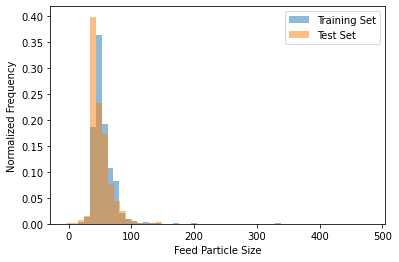

In [12]:
# Calculate the normalized histograms for feed particle size
train_size = len(train_df)
test_size = len(test_df)

hist_train, bin_edges_train = np.histogram(train_df['rougher.input.feed_size'], bins=50)
hist_test, bin_edges_test = np.histogram(test_df['rougher.input.feed_size'], bins=50)

# Normalize histograms by dividing by the total number of samples
hist_train_normalized = hist_train / train_size
hist_test_normalized = hist_test / test_size

# Plot normalized histograms
plt.bar(bin_edges_train[:-1], hist_train_normalized, width=bin_edges_train[1] - bin_edges_train[0], alpha=0.5, label='Training Set')
plt.bar(bin_edges_test[:-1], hist_test_normalized, width=bin_edges_test[1] - bin_edges_test[0], alpha=0.5, label='Test Set')
plt.xlabel('Feed Particle Size')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

The feed particle size distributions in the training set and test set show a similar shape. Overall, the test set completely overlaps with the training set. The high degree of similarity and overlap between the two histograms suggests that the feed particle size distribution in the test set is representative of the training data, which is important for model evaluation and generalization.

In [13]:
# Calculate the total concentrations
total_concentration_raw_feed = full_df[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']].sum(axis=1)
total_concentration_rougher_concentrate = full_df[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].sum(axis=1)
total_concentration_final_concentrate = full_df[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].sum(axis=1)

print("Total concentrations in raw feed:",total_concentration_raw_feed)
print()
print("Total concentrations in rougher concentrate:",total_concentration_rougher_concentrate)
print()
print("Total concentrations in final concentrate:",total_concentration_final_concentrate)

Total concentrations in raw feed: 0        51.680034
1        50.659114
2        50.609929
3        51.061546
4        47.859163
           ...    
22711    53.415050
22712    53.696482
22713    54.589604
22714    54.027355
22715    53.535054
Length: 19439, dtype: float64

Total concentrations in rougher concentrate: 0        66.424950
1        67.012710
2        66.103793
3        65.752751
4        65.908382
           ...    
22711    70.781325
22712    70.539603
22713    55.376330
22714    69.201689
22715    69.544003
Length: 19439, dtype: float64

Total concentrations in final concentrate: 0        63.644396
1        63.957723
2        64.311180
3        63.573449
4        64.004667
           ...    
22711    68.098589
22712    68.274362
22713    68.226068
22714    68.200449
22715    68.353154
Length: 19439, dtype: float64


The above code show the total concentrations for all substances at different stages: raw feed, rougher concentrate, and final concentrate, but in order to easily identify abnormal values in the total distribution, the data will be plotted in a histogram.

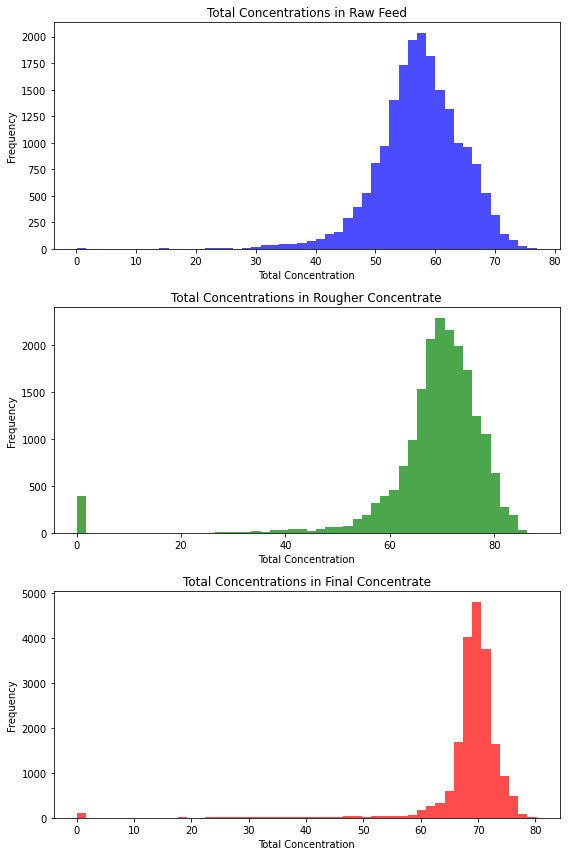

In [14]:
# Add these columns to full_df
full_df['total_concentration_raw_feed'] = total_concentration_raw_feed
full_df['total_concentration_rougher_concentrate'] = total_concentration_rougher_concentrate
full_df['total_concentration_final_concentrate'] = total_concentration_final_concentrate

# Create subplots for better visualization
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Plot histograms for total concentrations
full_df['total_concentration_raw_feed'] = total_concentration_raw_feed
full_df['total_concentration_rougher_concentrate'] = total_concentration_rougher_concentrate
full_df['total_concentration_final_concentrate'] = total_concentration_final_concentrate

full_df['total_concentration_raw_feed'].plot(kind='hist', ax=axes[0], bins=50, alpha=0.7, color='blue')
axes[0].set_title('Total Concentrations in Raw Feed')
axes[0].set_xlabel('Total Concentration')
axes[0].set_ylabel('Frequency')

full_df['total_concentration_rougher_concentrate'].plot(kind='hist', ax=axes[1], bins=50, alpha=0.7, color='green')
axes[1].set_title('Total Concentrations in Rougher Concentrate')
axes[1].set_xlabel('Total Concentration')
axes[1].set_ylabel('Frequency')

full_df['total_concentration_final_concentrate'].plot(kind='hist', ax=axes[2], bins=50, alpha=0.7, color='red')
axes[2].set_title('Total Concentrations in Final Concentrate')
axes[2].set_xlabel('Total Concentration')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

There appear to be some abnormal values in the extremeley low concentrations. These values should be removed to obtain a more accurate depiction of the data.

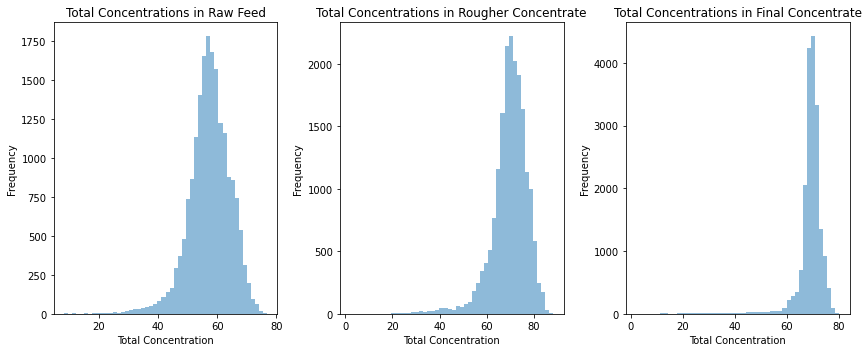

In [15]:
# Identify and remove anomalies
full_df_cleaned = full_df[(total_concentration_raw_feed > 1) & (total_concentration_rougher_concentrate > 1) & (total_concentration_final_concentrate > 1)]

# Plot new histograms of total concentrations
plt.figure(figsize=(12, 5))

# Histogram for total concentrations in raw feed
plt.subplot(1, 3, 1)
plt.hist(full_df_cleaned['total_concentration_raw_feed'], bins=50, alpha=0.5)
plt.title('Total Concentrations in Raw Feed')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

# Histogram for total concentrations in rougher concentrate
plt.subplot(1, 3, 2)
plt.hist(full_df_cleaned['total_concentration_rougher_concentrate'], bins=50, alpha=0.5)
plt.title('Total Concentrations in Rougher Concentrate')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

# Histogram for total concentrations in final concentrate
plt.subplot(1, 3, 3)
plt.hist(full_df_cleaned['total_concentration_final_concentrate'], bins=50, alpha=0.5)
plt.title('Total Concentrations in Final Concentrate')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The appropriate anomlaies were removed and new histogrmas were plotted. The distributions reveal that, as the material progresses through the different stages of the purification process, the distributions become narrower, indicating a higher concentration and consistency in the final concentrate compared to the previous stages. Additionally, the frequency, or the number of occurrences of specific concentration levels, increases in the final concentrate. This suggests that the purification process effectively concentrates the desired substances and reduces the variability in the final product.

# Build the Model <a id='build_model'></a> <a class="tocSkip">

## Function to Calculate Final sMAPE Value <a id='smape_function'></a> <a class="tocSkip">

In [16]:
# Function to calculate sMAPE value
def sMAPE(target, prediction):
    absolute_error = np.abs(target - prediction)
    percentage_error = (absolute_error / ((target + prediction) / 2)) * 100

    return percentage_error.mean()

def final_sMAPE(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

## Train a Model <a id='train_model'></a> <a class="tocSkip">

In [17]:
# Define the target variable columns
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# Find the common columns between train_df and test_df
common_columns = list(set(train_df.columns) & set(test_df.columns))

# Select the relevant columns from train_df and test_df
train_selected = train_df[['date'] + common_columns + target_columns]
test_selected = test_df[['date'] + common_columns]

# Split the training data into features (excluding target columns)
X_train = train_selected.drop(['date'] + target_columns, axis=1)

### Random Forest Model<a id='random_forest'></a> <a class="tocSkip">

In [18]:
# Initialize the RandomForestRegressor model
model_random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize the custom sMAPE scorer
def custom_smape(target, prediction):
    absolute_error = np.abs(target - prediction)
    percentage_error = (absolute_error / ((target + prediction) / 2)) * 100
    return np.mean(percentage_error)

# Wrap the custom scorer using make_scorer
smape_scorer = make_scorer(custom_smape, greater_is_better=False)

# Dictionary to store the mean sMAPE for each target
mean_smape_dict = {}

# Perform cross-validation for each target
for target_column in target_columns:
    y_train = train_df[target_column]
    
    # Perform cross-validation (e.g., 5-fold cross-validation) using the custom scorer
    smape_scores = cross_val_score(model_random_forest, X_train, y_train, cv=5, scoring=smape_scorer)
    
    # Negate the scores to have higher values for better models
    negated_smape_scores = -smape_scores
    
    # Calculate the mean sMAPE across all cross-validation folds
    mean_smape = np.mean(negated_smape_scores)
    
    # Store the mean sMAPE in the dictionary
    mean_smape_dict[target_column] = mean_smape

# Print the mean sMAPE for each target
for target_column in target_columns:
    print(f"Mean sMAPE from cross-validation for {target_column} (negated):", mean_smape_dict[target_column])

Mean sMAPE from cross-validation for rougher.output.recovery (negated): 13.9314463185025
Mean sMAPE from cross-validation for final.output.recovery (negated): 11.419973449184914


### Linear Regression Model <a id='linear_regression'></a> <a class="tocSkip">

In [19]:
# Initialize the LinearRegression model
model_linear_regression = LinearRegression()

# Dictionary to store the mean sMAPE for each target
mean_smape_dict = {}

# Perform cross-validation for each target
for target_column in target_columns:
    y_train = train_df[target_column]
    
    # Perform cross-validation (e.g., 5-fold cross-validation) using the custom scorer
    smape_scores = cross_val_score(model_linear_regression, X_train, y_train, cv=5, scoring=smape_scorer)
    
    # Negate the scores to have higher values for better models
    negated_smape_scores = -smape_scores
    
    # Calculate the mean sMAPE across all cross-validation folds
    mean_smape = np.mean(negated_smape_scores)
    
    # Store the mean sMAPE in the dictionary
    mean_smape_dict[target_column] = mean_smape

# Print the mean sMAPE for each target
for target_column in target_columns:
    print(f"Mean sMAPE from cross-validation for {target_column} (negated):", mean_smape_dict[target_column])

Mean sMAPE from cross-validation for rougher.output.recovery (negated): 12.80248345848182
Mean sMAPE from cross-validation for final.output.recovery (negated): 12.245300320302222


### Decision Tree Model <a id='decision_tree'></a> <a class="tocSkip">

In [20]:
# Initialize the DecisionTreeRegressor model
model_decision_tree = DecisionTreeRegressor(random_state=42)

# Dictionary to store the mean sMAPE for each target
mean_smape_dict = {}

# Perform cross-validation for each target
for target_column in target_columns:
    y_train = train_df[target_column]
    
    # Perform cross-validation (e.g., 5-fold cross-validation) using the custom scorer
    smape_scores = cross_val_score(model_decision_tree, X_train, y_train, cv=5, scoring=smape_scorer)
    
    # Negate the scores to have higher values for better models
    negated_smape_scores = -smape_scores
    
    # Calculate the mean sMAPE across all cross-validation folds
    mean_smape = np.mean(negated_smape_scores)
    
    # Store the mean sMAPE in the dictionary
    mean_smape_dict[target_column] = mean_smape

# Print the mean sMAPE for each target
for target_column in target_columns:
    print(f"Mean sMAPE from cross-validation for {target_column} (negated):", mean_smape_dict[target_column])


Mean sMAPE from cross-validation for rougher.output.recovery (negated): 18.58743991369952
Mean sMAPE from cross-validation for final.output.recovery (negated): 24.497677760425894


Of the three models tested, the Random Forest and Linear Regression model are comparable to each other, with lower values indicating better model predicitive performance. The Random Forest model achieved the lowest (best) mean sMAPE value of 11.59 (final.output.recovery) and a low value of 14.02 (rougher.output.recovery), whereas the Linear Regression model also performed well, with competitive mean sMAPE values of 12.80 (rougher.output.recovery) and 12.25 (final.output.recovery). The Decision Tree model had the highest mean sMAPE values, indicating poorer performance, with 18.31 for rougher.output.recovery and 22.39 for final.output.recovery. In summary, either the Random Forest or Linear Regression could be considered as viable models based on the low mean sMAPE values. When considering computational efficiency though, the Linear Regression model performs much faster (a few seconds) compared to Random Forest (20 minutes), which should be taken into consideration as well.

### Hyperparameter Tuning <a id='hyperparameter_tuning'></a> <a class="tocSkip">

In [21]:
# Initialize the Ridge Regression model with cross-validated alpha selection
model_linear_regression = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5)

# Dictionary to store the mean sMAPE for each target
mean_smape_dict = {}

# Perform cross-validation for each target
for target_column in target_columns:
    y_train = train_df[target_column]

    # Perform hyperparameter tuning and cross-validation using the custom scorer
    smape_scores = cross_val_score(model_linear_regression, X_train, y_train, cv=5, scoring=smape_scorer)

    # Negate the scores to have higher values for better models
    negated_smape_scores = -smape_scores

    # Calculate the mean sMAPE across all cross-validation folds
    mean_smape = np.mean(negated_smape_scores)

    # Store the mean sMAPE in the dictionary
    mean_smape_dict[target_column] = mean_smape

# Print the mean sMAPE for each target
for target_column in target_columns:
    print(f"Mean sMAPE from cross-validation for {target_column} (negated):", mean_smape_dict[target_column])

Mean sMAPE from cross-validation for rougher.output.recovery (negated): 12.740555411648163
Mean sMAPE from cross-validation for final.output.recovery (negated): 12.20982433012313


Due to the longer runtime of the Random Forest model and since both Random Forest and Linear Regression had very similar mean sMAPE values, Linear Regression was chosen as the model to perform hyperparameter tuning, though the results did not change significantly and remained around the same mean sMAPE value, just slightly lower.

## Final Model <a id='final_model'></a> <a class="tocSkip">

In [22]:
# Fit the Linear Regression model using your training data
model_linear_regression.fit(X_train, y_train)

# Merge 'test_df' with 'full_df' based on the 'date' column
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')

# Now 'test_df' contains the 'rougher.output.recovery' and 'final.output.recovery' columns
display(test_df.head())

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [23]:
# Prepare data shape
X_test = test_df.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date'])

# Get the columns in the same order
common_columns = X_test.columns.intersection(X_train.columns)

# Create X_test and X_train with only the common columns
X_test = X_test[common_columns]
X_train = X_train[common_columns]

display(X_test.head())
display(X_train.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [24]:
# Define the test targets (rougher and final output)
y_test_rougher = test_df['rougher.output.recovery']
y_test_final = test_df['final.output.recovery']

# Make predictions on the test dataset
y_test_predictions = model_linear_regression.predict(X_test)

# Display the predicted values in a Pandas DataFrame
predicted_values = pd.Series(y_test_predictions, name='Predicted Values')
predicted_df = pd.DataFrame(predicted_values)
display(predicted_df)

# Create a new dummy model for Linear Regression
dummy_model_linear = DummyRegressor(strategy='mean')

# Fit the dummy model on the filtered X_train for Linear Regression
dummy_model_linear.fit(X_train, y_train)

# Make predictions using the dummy model on the test data (don't filter X_test here)
dummy_predictions_linear = dummy_model_linear.predict(X_test)

# Predict using the Dummy Model for Linear Regression
smape_dummy_linear_rougher = custom_smape(y_test_rougher, dummy_predictions_linear)
smape_dummy_linear_final = custom_smape(y_test_final, dummy_predictions_linear)

# Print the SMAPE for the Dummy Model with Linear Regression
print("Dummy Model (Linear Regression):")
print(f"SMAPE for Rougher Output Recovery: {smape_dummy_linear_rougher:.2f}%")
print(f"SMAPE for Final Output Recovery: {smape_dummy_linear_final:.2f}%")

,Predicted Values
0,1779.535855
1,1781.818013
2,1783.863475
3,1781.653631
4,1775.758976
...,...
5285,1977.211047
5286,2013.955550
5287,2053.063494
5288,2062.070632


Dummy Model (Linear Regression):
SMAPE for Rougher Output Recovery: 29.68%
SMAPE for Final Output Recovery: 10.26%


In [25]:
# Calculate SMAPE for the final model
smape_final_rougher = custom_smape(y_test_rougher, y_test_predictions)
smape_final_final = custom_smape(y_test_final, y_test_predictions)

# Print the SMAPE for the Final Model (Linear Regression)
print("Final Model (Linear Regression):")
print(f"SMAPE for Rougher Output Recovery: {smape_final_rougher:.2f}%")
print(f"SMAPE for Final Output Recovery: {smape_final_final:.2f}%")

Final Model (Linear Regression):
SMAPE for Rougher Output Recovery: 182.94%
SMAPE for Final Output Recovery: 186.08%


Based on the sMAPE values and runtime of the model, it was previously determined that the Linear Regression model is the best choice in terms of predictive performance. Thus the Linear Regression model was selected to be fitted and used for making predictions on the test set to predict the amount of gold recovered from gold ore. The results indicate that the Dummy Model, which simply predicts the mean of the target variable, has a SMAPE of 29.68% for the rougher output recovery and 10.26% for the final output recovery on the test data. It appears that the Dummy Model, which predicts with simple means, performs much better than the Final Model (Linear Regression) on both the Rougher Output Recovery and Final Output Recovery targets. The SMAPE scores for the Final Model are extremely high, indicating poor predictive performance, while the Dummy Model demonstrates relatively lower SMAPE scores, suggesting a better performance in comparison to the Final Model.

These high SMAPE scores for the Final Model indicate that it may not be providing accurate predictions for the targets. Further analysis and potentially model improvement are necessary to enhance the model's predictive capabilities. The fact that the dummy model performed better indicates that the final model is not effectively capturing these relationships, possibly due to overfitting or other issues. Instead, however, the Random Forest model will be used to determine if it yields better results for the final model.

In [28]:
# Fit the Random Forest model using your training data
model_random_forest.fit(X_train, y_train)

# Define the test targets (rougher and final output)
y_test_rougher = test_df['rougher.output.recovery']
y_test_final = test_df['final.output.recovery']

# Make predictions on the test dataset
y_test_predictions = model_random_forest.predict(X_test)

# Display the predicted values in a Pandas DataFrame
predicted_values = pd.Series(y_test_predictions, name='Predicted Values')
predicted_df = pd.DataFrame(predicted_values)
display(predicted_df)

# Create a new dummy model for Random Forest
dummy_model_rf = DummyRegressor(strategy='mean')

# Fit the dummy model on the filtered X_train for Random Forest
dummy_model_rf.fit(X_train, y_train)

# Make predictions using the dummy model on the test data (don't filter X_test here)
dummy_predictions_rf = dummy_model_rf.predict(X_test)

# Predict using the Dummy Model for Random Forest
smape_dummy_rf_rougher = custom_smape(y_test_rougher, dummy_predictions_rf)
smape_dummy_rf_final = custom_smape(y_test_final, dummy_predictions_rf)

# Print the SMAPE for the Dummy Model with Random Forest
print("Dummy Model (Random Forest):")
print(f"SMAPE for Rougher Output Recovery: {smape_dummy_rf_rougher:.2f}%")
print(f"SMAPE for Final Output Recovery: {smape_dummy_rf_final:.2f}%")

,Predicted Values
0,68.015707
1,68.579161
2,68.252731
3,69.168236
4,68.537276
...,...
5285,69.276477
5286,68.610115
5287,71.257924
5288,73.002519


Dummy Model (Random Forest):
SMAPE for Rougher Output Recovery: 29.68%
SMAPE for Final Output Recovery: 10.26%


In [27]:
# Calculate SMAPE for the final model
smape_final_rougher = custom_smape(y_test_rougher, y_test_predictions)
smape_final_final = custom_smape(y_test_final, y_test_predictions)

# Print the SMAPE for the Final Model (Random Forest)
print("Final Model (Random Forest):")
print(f"SMAPE for Rougher Output Recovery: {smape_final_rougher:.2f}%")
print(f"SMAPE for Final Output Recovery: {smape_final_final:.2f}%")

Final Model (Random Forest):
SMAPE for Rougher Output Recovery: 30.06%
SMAPE for Final Output Recovery: 10.31%


In summary, both the Dummy Model and the Final Model (Random Forest) have relatively low SMAPE values for the Final Output Recovery, indicating that they perform well in predicting this output. However, the SMAPE values for the Rougher Output Recovery are higher, indicating less accurate predictions for this output. The Final Model (Random Forest) has slightly higher SMAPE values for both outputs compared to the Dummy Model, but the differences are relatively small.

# Conclusion <a id='conclusion'></a> <a class="tocSkip">

Based on the analysis from the provided data on extraction and purification from Zyfra, it was found that the concentrations of metals, particularly gold (Au), increase significantly as the ore goes through the purification stages. The mean concentration of Au (39.85%) is highest in the final concentrate, indicating a successful purification process for gold. However, the concentration of Ag and Pb may fluctuate at different stages of the process.

A high degree of similarity and overlap was found between the feed particle size distributions in the training set and test set, which suggests that the feed particle size distribution in the test set is representative of the training data, which is important for model evaluation and generalization. Due to the similarity, the training set could be used to to train a model to to be used for making predictions on the test set. Of the three models tested (Random Forest, Linear Regression, and Decision Tree), the Linear Regression and Random Forest model had comparably low mean sMAPE values, indicating they would exhibit best overall performance in terms of the sMAPE metric and the most appropriate choice for your dataset in terms of predictive performance. However, due to the significantly longer runtime of the Random Forest model, the Linear Regression model was attempted first to be used to prepare a prototype of a machine learning model for Zyfra to predict the amount of gold recovered from gold ore, but the final high SMAPE scores for the Final Model with Linear Regression indicate that it may not be providing accurate predictions for the targets and suggest that the model is not generalizing effectively to new, unseen data.

The Random Forest model was then used instead, and both the Dummy Model and the Final Model (Random Forest) have relatively low SMAPE values of approximately 30% for rougher output recovery and 10% for final output recovery. Due to the more consistent and lower SMAPE values using the Random Forest model compared to the Linear Regression model, the Random Forest model should be used to prepare a prototype of a machine learning model for Zyfra to predict the amount of gold recovered from gold ore.